# Domestic Flights since January 2014

Data sources:

Bureau of Transportation Statistics, United States Department of Transportation [On-Time Performance](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236)

# Download domestic flight data from BTS since January 2014

Manually downloaded airline [On-Time Performance data set](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236) for every month from January 2014 through 2017 YTD as zip files to `raw_data/flights_since_2014/`.

# Import libraries

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import re
import datetime
import calendar
from tqdm import tqdm
%matplotlib inline

# Helper functions to clean and wrangle the data

In [5]:
def load_data(path_to_data):
    """
    Loads the monthly zip files downloaded from BTS into a single data frame
    """
    list_of_dataframes = []

    for filename in tqdm(os.listdir(path_to_data)):
        df = pd.read_csv(os.path.join(path_to_data, filename), compression='infer')
        list_of_dataframes.append(df)
    
    output = pd.concat(list_of_dataframes)
    
    return output 

In [6]:
def parse_time_stamps(hhmm):
    """
    DEP_TIME, ARR_TIME come in a weird format: "hhmm" (local time).
    """
    hhmm = str(int(hhmm)).zfill(4)
    hh = int(hhmm[:2])
    hh = hh % 24
    mm = int(hhmm[2:])
    timestamp = datetime.time(hour=hh, minute=mm)
    return timestamp

In [7]:
def clean_flights(df):
    
    # Drop any columns with "Unnamed" in the header
    drop_columns = [i for i in df.columns if 'Unnamed' in i]
    df = df.drop(drop_columns, axis=1)
    
    # Drop rows with NaN for ARR_TIME, DEP_TIME or FL_DATE
    df = df.dropna(subset=['ARR_TIME', 'DEP_TIME', 'FL_DATE'])
    df = df.reset_index(drop=True)
    
    # Parse DEP_TIME and ARR_TIME to time stamps
    df['DEP_TIME_STAMP'] = df['DEP_TIME'].apply(parse_time_stamps)
    df['ARR_TIME_STAMP'] = df['ARR_TIME'].apply(parse_time_stamps)
    
    # For rows where arr_time is before dep_time, increment date by one day
    dep_datetimes =  []
    arr_datetimes = []
    for i in tqdm(df.index):
        row = df.loc[i]
        dep_time = row['DEP_TIME_STAMP']
        arr_time = row['ARR_TIME_STAMP']
        dep_datetime = pd.to_datetime(row['FL_DATE'] + " " + str(dep_time))
        dep_datetimes.append(dep_datetime)
        arr_datetime = pd.to_datetime(row['FL_DATE'] + " " + str(arr_time))
      
        if (arr_time < dep_time):
            arr_datetimes.append(arr_datetime + datetime.timedelta(days=1))
        else:
            arr_datetimes.append(arr_datetime)
    
    df['DEP_DATETIME'] = dep_datetimes
    df['ARR_DATETIME'] = arr_datetimes
    df['FL_DURATION'] = (df['ARR_DATETIME'] - df['DEP_DATETIME']).dt.total_seconds()
    
    # Keep only the columns we want
    df = df[['FL_DATE', 'DEP_DATETIME', 'ARR_DATETIME', 'TAIL_NUM', 
             'ORIGIN', 'ORIGIN_CITY_NAME','DEST', 'DEST_CITY_NAME',
             'CANCELLATION_CODE', 'CANCELLED', 'LATE_AIRCRAFT_DELAY',
             'NAS_DELAY', 'ARR_DELAY', 'DEP_DELAY', 'LATE_AIRCRAFT_DELAY',
             'WEATHER_DELAY']]
    
    df = df.sort_values(by=['DEP_DATETIME', 'ARR_DATETIME'])
    df = df.reset_index(drop=True)
    
    return df

In [8]:
def get_cancelled_flights(df):
    
    # Drop any columns with "Unnamed" in the header
    drop_columns = [i for i in df.columns if 'Unnamed' in i]
    df = df.drop(drop_columns, axis=1)

    # Keep only the columns we want
    df = df[['FL_DATE', 'DEP_TIME', 'ARR_TIME', 'TAIL_NUM', 
             'ORIGIN', 'ORIGIN_CITY_NAME','DEST', 'DEST_CITY_NAME',
             'CANCELLATION_CODE', 'CANCELLED', 'LATE_AIRCRAFT_DELAY',
             'NAS_DELAY', 'ARR_DELAY', 'DEP_DELAY', 'LATE_AIRCRAFT_DELAY',
             'WEATHER_DELAY']]
    
    df = df[df['CANCELLED'] == 1.0]
    df = df.reset_index(drop=True)
    
    return df

# Load flight data into dataframes

Get all of the domestic flights in or out of NY State since 2014.

In [12]:
domestic_flights_since_2014 = load_data("../raw_data/flights_since_2014")

  0%|          | 0/45 [00:00<?, ?it/s]/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (77,84) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
  4%|▍         | 2/45 [00:00<00:12,  3.50it/s]/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
 29%|██▉       | 13/45 [00:08<00:21,  1.50it/s]/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (69,76) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
 31%|███       | 14/45 [00:09<00:20,  1.49it/s]/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (76,77,84) have mixed types. Specify dtype option on import or set low_memory=Fal

Clean the LGA arrivals flights.

In [13]:
lga_arrivals = domestic_flights_since_2014[domestic_flights_since_2014['DEST'] == 'LGA']
lga_arrivals = lga_arrivals.reset_index(drop=True)
lga_arrivals = clean_flights(lga_arrivals)

100%|██████████| 359055/359055 [02:38<00:00, 2265.96it/s]


Clean the LGA departing flights.

In [16]:
lga_departures = domestic_flights_since_2014[domestic_flights_since_2014['ORIGIN'] == 'LGA']
lga_departures = lga_departures.reset_index(drop=True)
lga_departures = clean_flights(lga_departures)

100%|██████████| 359551/359551 [02:25<00:00, 2470.33it/s]


Get cancelled LGA arrivals and departures.

In [17]:
lga_cancelled_flights = get_cancelled_flights(domestic_flights_since_2014)
lga_cancelled_arrivals = lga_cancelled_flights[lga_cancelled_flights['DEST'] == 'LGA']
lga_cancelled_departures = lga_cancelled_flights[lga_cancelled_flights['ORIGIN'] == 'LGA']

# Number of flights arriving at LGA per hour since 2014

In [14]:
def count_flights_per_hour(df):
    
    # Make dataframe of number of flights per hour since 2014
    output = df['DEP_DATETIME']
    output.index = df['DEP_DATETIME']
    output = pd.DataFrame(output.groupby(pd.TimeGrouper(freq='H')).count().sort_index())
    output.columns = ['NUM_FLIGHTS']
    
    return output

In [15]:
flights_per_hour = count_flights_per_hour(lga_arrivals)

In [16]:
flights_per_hour.head()

,NUM_FLIGHTS
DEP_DATETIME,
2014-01-01 00:00:00,1
2014-01-01 01:00:00,0
2014-01-01 02:00:00,0
2014-01-01 03:00:00,0
2014-01-01 04:00:00,0


In [17]:
flights_per_hour.tail()

,NUM_FLIGHTS
DEP_DATETIME,
2017-08-31 18:00:00,15
2017-08-31 19:00:00,19
2017-08-31 20:00:00,10
2017-08-31 21:00:00,2
2017-08-31 22:00:00,2


# Scrape FAA.gov to Map Tail Numbers to Aircraft Models

Federal Aviation Administration has a tail number query data service. Here is an example: http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt=N14249.

Make a list of unique tail numbers of flights arriving at LGA.

In [19]:
arriving_tail_nums = np.array(lga_arrivals['TAIL_NUM'])
arriving_tail_nums = arriving_tail_nums[~pd.isnull(arriving_tail_nums)] # remove nan's
#departing_tail_nums = np.array(lga_departures['TAIL_NUM'])
#departing_tail_nums = departing_tail_nums[~pd.isnull(departing_tail_nums)]

#unique_tail_nums = np.unique(list(arriving_tail_nums) + list(departing_tail_nums)) # get unique tail nums
#print len(unique_tail_nums), "unique tail numbers arrived at LGA since 2014"

In [20]:
import urllib2
from BeautifulSoup import BeautifulSoup
from collections import defaultdict

In [21]:
tail_num = "N14249"
print "Tail Number:", tail_num

root_url = "http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt={}"
url = root_url.format(tail_num)
req = urllib2.Request(url)
html = urllib2.urlopen(req).read()
soup = BeautifulSoup(html)

# Get manufacturer
manufacturer = soup.find("span", id="content_lbMfrName").text
print "Manufacturer:", manufacturer

# Get aircraft model
model = soup.find("span", id='content_Label7').text
print "Model:", model

Tail Number: N14249
Manufacturer: BOEING
Model: 737-824


In [22]:
def match_tail_num_to_model(unique_tail_nums):
    
    count = 0

    results = defaultdict(dict)
    failures = []
    root_url = "http://registry.faa.gov/aircraftinquiry/NNum_Results.aspx?NNumbertxt={}"
    
    for tail_num in tqdm(unique_tail_nums):

        url = root_url.format(tail_num)
        req = urllib2.Request(url)
        html = urllib2.urlopen(req).read()
        soup = BeautifulSoup(html)

        try:
            # Get manufacturer
            manufacturer = soup.find("span", id="content_lbMfrName").text
            results[tail_num]['manufacturer'] = manufacturer

            # Get aircraft model
            model = soup.find("span", id='content_Label7').text
            results[tail_num]['model'] = model
            
            # Get airline
            airline = soup.find("span", id='content_lbOwnerName').text
            results[tail_num]['airline'] = airline
        
        except:
            failures.append(tail_num)
            
        count += 1
            
    return results, failures

In [30]:
tail_num_models, tail_num_unknown = match_tail_num_to_model(unique_tail_nums)

100%|██████████| 4183/4183 [34:03<00:00,  2.05it/s]


In [31]:
tail_num_models_df = pd.DataFrame(tail_num_models).transpose()

In [37]:
tail_num_models_df.head()

,tail_number,airline,manufacturer,model
0,7819A,WILMINGTON TRUST CO TRUSTEE,BOEING,737-7Q8
1,7820L,WILMINGTON TRUST CO TRUSTEE,BOEING,737-79P
2,N10156,WELLS FARGO BANK NORTHWEST NA TRUSTEE,EMBRAER,EMB-145XR
3,N102AA,CHICO CREEK AVIATION SERVICES LLC,AVIAT AIRCRAFT INC,A-1B
4,N102UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214


In [33]:
print "Found model names for {} tail numbers".format(len(tail_num_models_df))

Found model names for 3328 tail numbers


In [34]:
print "Failed to find model names for {} tail numbers:".format(len(tail_num_unknown))

Failed to find model names for 855 tail numbers:


In [28]:
# Save to csv
#tail_num_models_df.to_csv("../raw_data/tail_number_aircraft_model/tail_number_aircraft_model_since_2014.csv")
#tail_num_models_df = pd.read_csv("../raw_data/tail_number_aircraft_model/tail_number_aircraft_model_since_2014.csv")
#tail_num_models_df.rename(columns={'Unnamed: 0': 'tail_number'}, inplace=True)

In [23]:
def read_tail_num_models(path_to_data):
    tail_num_models_df = pd.read_csv("../raw_data/tail_number_aircraft_model/tail_number_aircraft_model.csv")
    tail_num_models_df = tail_num_models_df.rename(columns={'Unnamed: 0': 'tail_number'})
    tail_num_models_df['manufacturer_short'] = tail_num_models_df['manufacturer'].apply(lambda x: x.split(" ")[0])
    tail_num_models_df['model_short'] = tail_num_models_df['model'].apply(lambda x: x.split("-")[0])
    tail_num_models_df['manufacturer_model'] = tail_num_models_df['manufacturer_short'] + " " + tail_num_models_df['model_short']
    return tail_num_models_df

In [24]:
tail_num_models_df = read_tail_num_models("../raw_data/tail_number_aircraft_model/tail_number_aircraft_model.csv")

In [39]:
tail_num_models_df.head()

,tail_number,airline,manufacturer,model
0,7819A,WILMINGTON TRUST CO TRUSTEE,BOEING,737-7Q8
1,7820L,WILMINGTON TRUST CO TRUSTEE,BOEING,737-79P
2,N10156,WELLS FARGO BANK NORTHWEST NA TRUSTEE,EMBRAER,EMB-145XR
3,N102AA,CHICO CREEK AVIATION SERVICES LLC,AVIAT AIRCRAFT INC,A-1B
4,N102UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214


# Map Tail Number to Aircraft Manufacturer and Model

In [25]:
lga_arrivals = pd.merge(lga_arrivals, tail_num_models_df, how='left', left_on='TAIL_NUM', right_on='tail_number')

In [26]:
lga_arrivals.head()

,FL_DATE,DEP_DATETIME,ARR_DATETIME,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CANCELLATION_CODE,CANCELLED,...,DEP_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,tail_number,airline,manufacturer,model,manufacturer_short,model_short,manufacturer_model
0,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,274.0,113.0,161.0,N8312C,SOUTHWEST AIRLINES CO,BOEING,737-8H4,BOEING,737,BOEING 737
1,2014-01-01,2014-01-01 05:53:00,2014-01-01 07:17:00,N813MQ,RDU,"Raleigh/Durham, NC",LGA,"New York, NY",NaN,0.0,...,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-01,2014-01-01 05:55:00,2014-01-01 08:19:00,N589JB,MCO,"Orlando, FL",LGA,"New York, NY",NaN,0.0,...,-5.0,NaN,NaN,N589JB,JETBLUE AIRWAYS CORP,AIRBUS,A320-232,AIRBUS,A320,AIRBUS A320
3,2014-01-01,2014-01-01 05:59:00,2014-01-01 08:30:00,N520JB,FLL,"Fort Lauderdale, FL",LGA,"New York, NY",NaN,0.0,...,-1.0,NaN,NaN,N520JB,JETBLUE AIRWAYS CORP,AIRBUS INDUSTRIE,A320-232,AIRBUS,A320,AIRBUS A320
4,2014-01-01,2014-01-01 06:05:00,2014-01-01 09:24:00,N856MQ,BNA,"Nashville, TN",LGA,"New York, NY",NaN,0.0,...,-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Scrape Seatguru to Map Aircraft Models to Seat Counts

Adam scraped a data base of aircraft models and seats. Let's try to match those to the unique tail numbers found above.

In [27]:
def read_seat_capacity_data(path_to_data):
    seat_capacity = pd.read_csv(path_to_data)
    del seat_capacity['Unnamed: 0']
    
    seat_capacity['Manufacturer_Short'] = seat_capacity['Aircraft'].apply(lambda x: x.split("-")[0].split(" ")[:1][0])
    seat_capacity['Manufacturer_Model'] = seat_capacity['Aircraft'].apply(lambda x: x.split("-")[0].split("(")[0])
    seat_capacity['Model'] = seat_capacity['Aircraft'].apply(lambda x: x.split("(")[0].split(" ")[1])
    seat_capacity['Model_Short'] = seat_capacity['Model'].apply(lambda x: x.split("-")[0])

    # Do some stuff to deal with weird Embraer naming conventions
    model_short_numbers = []
    for i in seat_capacity.index:
        model_short = seat_capacity.loc[i]['Model_Short']
        model_short_num = re.findall('\d+', seat_capacity.loc[i]['Model_Short'])
        if len(model_short_num) == 0:
            model_short_num = re.findall('\d+', seat_capacity.loc[i]['Model'])
        try: 
            model_short_num = model_short_num[0]
        except:
            model_short_num = np.nan
        model_short_numbers.append(model_short_num)

    seat_capacity['Model_Short_Number'] = model_short_numbers
    return seat_capacity

In [28]:
seat_capacity = read_seat_capacity_data("../raw_data/seat_capacity/seat_capacity.csv")

In [29]:
seat_capacity.head()

,Airline,Aircraft,Seats,Manufacturer_Short,Manufacturer_Model,Model,Model_Short,Model_Short_Number
0,American_Airlines,Airbus A330-200 (332),258,Airbus,Airbus A330,A330-200,A330,330
1,American_Airlines,Airbus A330-300 (333),291,Airbus,Airbus A330,A330-300,A330,330
2,American_Airlines,Boeing 767-300 (763) V1,218,Boeing,Boeing 767,767-300,767,767
3,American_Airlines,Boeing 767-300 (763) V2,209,Boeing,Boeing 767,767-300,767,767
4,American_Airlines,Boeing 777-200 (777) V1,247,Boeing,Boeing 777,777-200,777,777


# Map Tail Number to Seat Count

In [30]:
tail_num_models_df.loc[1]

tail_number                                 7820L
airline               WILMINGTON TRUST CO TRUSTEE
manufacturer                               BOEING
model                                     737-79P
manufacturer_short                         BOEING
model_short                                   737
manufacturer_model                     BOEING 737
Name: 1, dtype: object

In [31]:
seat_capacity.loc[1]

Airline                   American_Airlines
Aircraft              Airbus A330-300 (333)
Seats                                   291
Manufacturer_Short                   Airbus
Manufacturer_Model              Airbus A330
Model                              A330-300
Model_Short                            A330
Model_Short_Number                      330
Name: 1, dtype: object

In [32]:
def match_tail_num_to_seat_capacity(tail_num_models_df, seat_capacity):

    seats_list = []
    seats_unknown = []

    for i in tail_num_models_df.index:

        plane = tail_num_models_df.loc[i]

        # Filter by manufacturer
        filtered = seat_capacity[seat_capacity['Manufacturer_Short'] == plane['manufacturer_short'].title()]

        # Look for exact matching model number
        if plane['model'] in filtered['Model']:
            seats = filtered[filtered['Model'] == plane['model']]['Seats']
            seats_list.append(seats)

        # Else look for matching model_short number and take average seat count
        elif len(filtered[filtered['Model_Short'] == plane['model_short']]) > 0:
            seats = int(np.mean(filtered[filtered['Model_Short'] == plane['model_short']]['Seats']))
            seats_list.append(seats)

        # Handle McDonnell Airlines separately
        elif plane['manufacturer_short'] == 'MCDONNELL':
            filter_mcdonnell = seat_capacity[seat_capacity['Manufacturer_Short'] == 'McDonnell']
            seats = int(np.mean(filter_mcdonnell['Seats']))
            seats_list.append(seats)

        # Handle Embraer separately
        elif plane['manufacturer_short'] == 'EMBRAER':
            filter_embraer = seat_capacity[seat_capacity['Manufacturer_Short'] == 'Embraer']
            model_short_num = re.findall('\d+', plane['model_short'])[0]
            filter_embraer = filter_embraer[filter_embraer['Model_Short_Number'] == model_short_num]
            seats = int(np.mean(filter_embraer['Seats']))
            seats_list.append(seats)
            
        # Handle Bombardier separately
        elif plane['manufacturer_short'] == 'BOMBARDIER':
            filter_bombardier = seat_capacity[seat_capacity['Manufacturer_Short'] == 'Bombardier']
            seats = int(np.mean(filter_bombardier['Seats']))
            seats_list.append(seats)

        else:
            seats_list.append(np.nan)
            seats_unknown.append(plane)
            
    return seats_list, seats_unknown

In [33]:
seats_list, seats_unknown = match_tail_num_to_seat_capacity(tail_num_models_df, seat_capacity)

In [34]:
print len(seats_list) - len(seats_unknown), "tail numbers matched to seat capacity"

2867 tail numbers matched to seat capacity


In [35]:
print len(seats_unknown), "tail numbers with unknown seat capacity"

144 tail numbers with unknown seat capacity


In [36]:
tail_num_models_df['seats'] = seats_list

In [37]:
tail_num_models_df.head(10)

,tail_number,airline,manufacturer,model,manufacturer_short,model_short,manufacturer_model,seats
0,7819A,WILMINGTON TRUST CO TRUSTEE,BOEING,737-7Q8,BOEING,737,BOEING 737,150.0
1,7820L,WILMINGTON TRUST CO TRUSTEE,BOEING,737-79P,BOEING,737,BOEING 737,150.0
2,N102AA,CHICO CREEK AVIATION SERVICES LLC,AVIAT AIRCRAFT INC,A-1B,AVIAT,A,AVIAT A,NaN
3,N102UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
4,N103AA,SMITH GEORGE BARKER,AVIAT AIRCRAFT INC,A-1B,AVIAT,A,AVIAT A,NaN
5,N103SY,SKYWEST AIRLINES INC,EMBRAER S A,ERJ 170-200 LR,EMBRAER,ERJ 170,EMBRAER ERJ 170,69.0
6,N103US,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
7,N104UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
8,N10575,WELLS FARGO BANK NORTHWEST NA TRUSTEE,EMBRAER,EMB-145LR,EMBRAER,EMB,EMBRAER EMB,51.0
9,N105AA,WEHRMACHER JAMES P,CESSNA,R182,CESSNA,R182,CESSNA R182,NaN


In [68]:
# save to csv
# tail_num_models_df.to_csv("../raw_data/tail_number_seat_capacity/tail_numbers_seat_capacity.csv")

# Estimate Seat Utilization Rate

Source: http://www.aviationdb.com/Aviation/F4SDetailQuery.shtm#SUBMIT

Manually collected monthly csv files for utilization rates by [ ] for flights arriving at LGA.

In [111]:
utilization = pd.read_csv("../raw_data/seat_utilization/LGA_arriving_flights_since_2014.csv")
utilization['Seat Utilization'] = utilization['Seat Utilization'].apply(lambda x: x.replace("%","").replace("-","0")).astype(float)

In [112]:
lga_arrivals['month_airline'] = lga_arrivals['FL_DATE'].apply(lambda x: str(x).split("-")[0]) + "-" \
                                     + lga_arrivals['FL_DATE'].apply(lambda x: str(x).split("-")[1])  \
                                     + " " + lga_arrivals['airline']

In [113]:
airline_lookup = defaultdict(dict)

airline_lookup[    'AMERICAN AIRLINES INC' ] = 'American Airlines Inc. (Domestic)'
airline_lookup[    'DELTA AIR LINES'] = 'Delta Air Lines Inc. (Domestic)'
airline_lookup[    'DELTA AIR LINES INC'] = 'Delta Air Lines Inc. (Domestic)'
airline_lookup[    'DELTA AIRLINES INC'] = 'Delta Air Lines Inc. (Domestic)'
airline_lookup[    'EXPRESSJET AIRLINES INC'] = 'ExpressJet Airlines Inc. (Domestic)'
airline_lookup[    'JETBLUE AIRWAYS'] = 'JetBlue Airways (Domestic)'
airline_lookup[    'JET BLUE AIRWAYS CORP'] = 'JetBlue Airways (Domestic)'
airline_lookup[    'JETBLUE AIRWAYS CORP'] = 'JetBlue Airways (Domestic)'
airline_lookup[    'JETBLUE AIRWAYS CORPORATION'] = 'JetBlue Airways (Domestic)'
airline_lookup[    'SKY WEST AIRLINES INC'] = 'SkyWest Airlines Inc. (Domestic)'
airline_lookup[    'SKYWEST AIRLINES INC'] = 'SkyWest Airlines Inc. (Domestic)'
airline_lookup[    'SPIRIT AIRLINES INC'] = 'Spirit Air Lines (Domestic)'
airline_lookup[    'SOUTHWEST AIRLINES CO'] = 'Southwest Airlines Co. (Domestic)'
airline_lookup[    'UNITED AIRLINES INC'] = 'United Air Lines Inc. (Domestic)'

In [114]:
lga_arrivals['airline_name_2'] = lga_arrivals['airline'].apply(lambda x: airline_lookup[x])
lga_arrivals['month_airline_name_2'] = lga_arrivals['FL_DATE'].apply(lambda x: str(x).split("-")[0]) + "-" \
                                     + lga_arrivals['FL_DATE'].apply(lambda x: str(x).split("-")[1])  \
                                     + " " + lga_arrivals['airline_name_2'].apply(str)

In [115]:
utilization['month_airline_name_2'] = utilization['Year - Month'] + " " + utilization['Carrier']

In [127]:
lga_arrivals = pd.merge(lga_arrivals, utilization[['month_airline_name_2', 'Seat Utilization']],
        left_on = 'month_airline_name_2', right_on='month_airline_name_2', how='left')

In [128]:
tail_num_models_df.head()

,tail_number,airline,manufacturer,model,manufacturer_short,model_short,manufacturer_model,seats
0,7819A,WILMINGTON TRUST CO TRUSTEE,BOEING,737-7Q8,BOEING,737,BOEING 737,150.0
1,7820L,WILMINGTON TRUST CO TRUSTEE,BOEING,737-79P,BOEING,737,BOEING 737,150.0
2,N102AA,CHICO CREEK AVIATION SERVICES LLC,AVIAT AIRCRAFT INC,A-1B,AVIAT,A,AVIAT A,NaN
3,N102UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
4,N103AA,SMITH GEORGE BARKER,AVIAT AIRCRAFT INC,A-1B,AVIAT,A,AVIAT A,NaN


In [123]:
lga_arrivals = pd.merge(lga_arrivals, tail_num_models_df[['tail_number', 'seats']],how='left')

In [129]:
lga_arrivals.head()

,FL_DATE,DEP_DATETIME,ARR_DATETIME,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CANCELLATION_CODE,CANCELLED,...,model,manufacturer_short,model_short,manufacturer_model,month_airline,airline_name_2,month_airline_name_2,seats,Estimated Passenger Count,Seat Utilization
0,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,737-8H4,BOEING,737,BOEING 737,2014-01 SOUTHWEST AIRLINES CO,Southwest Airlines Co. (Domestic),2014-01 Southwest Airlines Co. (Domestic),150.0,108.00,72.0
1,2014-01-01,2014-01-01 05:53:00,2014-01-01 07:17:00,N813MQ,RDU,"Raleigh/Durham, NC",LGA,"New York, NY",NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,{},2014-01 {},NaN,NaN,NaN
2,2014-01-01,2014-01-01 05:55:00,2014-01-01 08:19:00,N589JB,MCO,"Orlando, FL",LGA,"New York, NY",NaN,0.0,...,A320-232,AIRBUS,A320,AIRBUS A320,2014-01 JETBLUE AIRWAYS CORP,JetBlue Airways (Domestic),2014-01 JetBlue Airways (Domestic),156.0,121.68,78.0
3,2014-01-01,2014-01-01 05:59:00,2014-01-01 08:30:00,N520JB,FLL,"Fort Lauderdale, FL",LGA,"New York, NY",NaN,0.0,...,A320-232,AIRBUS,A320,AIRBUS A320,2014-01 JETBLUE AIRWAYS CORP,JetBlue Airways (Domestic),2014-01 JetBlue Airways (Domestic),156.0,121.68,78.0
4,2014-01-01,2014-01-01 06:05:00,2014-01-01 09:24:00,N856MQ,BNA,"Nashville, TN",LGA,"New York, NY",NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,{},2014-01 {},NaN,NaN,NaN


In [130]:
lga_arrivals['Estimated Passenger Count'] = lga_arrivals['seats'] * lga_arrivals['Seat Utilization'] / 100

In [131]:
def count_seats_per_hour(df):
    # Make dataframe of number of flights per hour since 2014
    output = df[['DEP_DATETIME', 'Estimated Passenger Count']]
    output.index = df['DEP_DATETIME']
    del output.index.name
    output = pd.DataFrame(output.groupby(pd.TimeGrouper(freq='H')).sum()['Estimated Passenger Count'].sort_index())
    output = output.fillna(0)
    output.columns = ['Estimated Passenger Count']
    output['Estimated Passenger Count'] = output['Estimated Passenger Count'].astype(int)
    return output

In [132]:
seats_filled_by_hour = count_seats_per_hour(lga_arrivals)

In [148]:
seats_filled_by_hour = seats_filled_by_hour.loc[seats_filled_by_hour.index < pd.to_datetime('2017-08-01 02:00:00')]

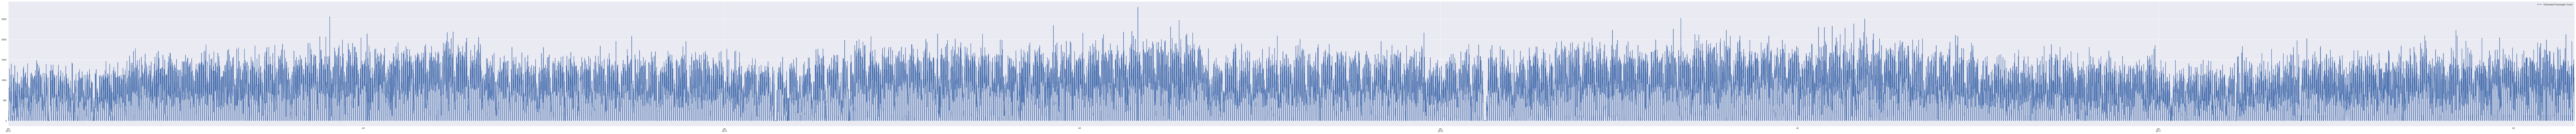

In [149]:
seats_filled_by_hour.plot(figsize=(200,10))

In [150]:
seats_filled_by_hour.to_csv("../clean_data/passengers_per_hour_since_2014.csv")

# The below is a work in progress...

Should we scrape seat counts from AviationDB instead? http://www.aviationdb.com/Aviation/Aircraft/7/N7819A.shtm

In [171]:
unique_carrier_names = set(utilization['Carrier'])
unique_airline_names = set(lga_arrivals[u'airline'])
unique_airline_names.remove(np.nan)

best_matches_old = defaultdict(dict)
for i in list(unique_airline_names):
    extract_one = process.extractOne(i, list(unique_carrier_names))
    best_match = extract_one[0]
    score = extract_one[1]
    best_matches[i]['airline'] = best_match
    best_matches[i]['score'] = score

airline_lookup = {
    
    'AMERICAN AIRLINES INC': 'American Airlines Inc. (Domestic)',
    'DELTA AIR LINES': 'Delta Air Lines Inc. (Domestic)',
    'DELTA AIR LINES INC': 'Delta Air Lines Inc. (Domestic)',
    'DELTA AIRLINES INC': 'Delta Air Lines Inc. (Domestic)',
    'EXPRESSJET AIRLINES INC': 'ExpressJet Airlines Inc. (Domestic)',
    'JETBLUE AIRWAYS': 'JetBlue Airways (Domestic)',
    'JET BLUE AIRWAYS CORP': 'JetBlue Airways (Domestic)',
    'JETBLUE AIRWAYS CORP': 'JetBlue Airways (Domestic)',
    'JETBLUE AIRWAYS CORPORATION': 'JetBlue Airways (Domestic)',
    'SKY WEST AIRLINES INC': 'SkyWest Airlines Inc. (Domestic)',
    'SKYWEST AIRLINES INC': 'SkyWest Airlines Inc. (Domestic)',
    'SPIRIT AIRLINES INC': 'Spirit Air Lines (Domestic)',
    'SOUTHWEST AIRLINES CO': 'Southwest Airlines Co. (Domestic)',
    'UNITED AIRLINES INC': 'United Air Lines Inc. (Domestic)',
    
}

In [204]:
lga_arrivals['Year - Month airline'] = lga_arrivals['Year - Month'] + " " + lga_arrivals['airline']

In [205]:
lga_arrivals_drop_na_airline = lga_arrivals.dropna(subset=['airline'])

In [210]:
unique_airlines = list(set(lga_arrivals_drop_na_airline['airline']))
for i in unique_airlines:
    print i

['SOUTHWEST AIRLINES CO',
 'AWAS 2963 TRUST',
 'FALCON MSN 2898 TRUST',
 'SKY OPT LLC',
 'ALPHA AIR LLC',
 'WELLS FARGO BANK NORTHWEST NA  TRUSTEE',
 'SPIRIT AIRLINES INC',
 'ALC A320 7272 LLC',
 'WELLS FARGO BANK NW NA TRUSTEE',
 'WILMINGTON TRUST NA TRUSTEE',
 'AVANT AVIATION LLC',
 'WELLS FARGO BANK NORTHWEST N A TRUSTEE',
 'DS 128 FLUGZEUGFONDS III TRUST',
 'ALPHA & OMEGA GROUP PC',
 'UNITED AIRLINES INC',
 'AMERICAN EAST AIRWAYS INC',
 'COAL AIR INC',
 'GAMMAGE COY W',
 'AFS INVESTMENTS 56 LLC',
 'EAGLE AIR MED CORP',
 'BUTLER TRACEY D',
 'FALCON MSN 2893 TRUST',
 'ROSSLAND DAVID T',
 'STUART S MACPHERSON DDS INC',
 'B & B AIR ACQUISITION 3417 STATUTORY TRUST',
 'DELTA AIRLINES INC',
 'ANTON AIR LLC',
 'MACLENNAN DONALD J',
 'FRIEDEMANN JON',
 'ALJ ENGINES SUPPLY INC',
 'BANK OF UTAH TRUSTEE',
 'ALL HOME CRAFTSMEN INC',
 'BIG MOUNTAIN AVIATION INC',
 'DAVISON INDUSTRIES INC',
 'SAVE A CONNIE INC',
 'AFS INVESTMENTS 48 LLC',
 'SKY WEST AIRLINES INC',
 'AFS INVESTMENTS XVIII LLC',
 

In [207]:
utilization

,Unnamed: 0,Year - Month,Carrier,Destination,Departures,Miles,Seats,Passengers,Seat Utilization,Payload (lbs),Freight (lbs),Mail (lbs)
0,1,2014-01,Air Canada (International),"New York, NY (LGA)",233,"82,835","23,060","14,001",61%,"6,058,613","6,439",0
1,2,2014-01,AirTran Airways Corporation (Domestic),"New York, NY (LGA)",188,"122,303","22,016","17,643",80%,"4,709,500","19,777",0
2,3,2014-01,Air Wisconsin Airlines Corp (Domestic),"New York, NY (LGA)",273,"59,158","13,650","9,435",69%,"6,425,006","3,489",100
3,4,2014-01,American Airlines Inc. (Domestic),"New York, NY (LGA)","1,169","1,252,618","174,068","134,035",77%,"46,521,200","75,781",0
4,5,2014-01,Atlas Air Inc. (Domestic),"New York, NY (LGA)",1,"1,381",102,57,56%,"95,240","23,455",0
5,6,2014-01,Chautauqua Airlines Inc. (Domestic),"New York, NY (LGA)",361,"163,798","18,050","10,318",57%,"4,146,446",0,0
6,7,2014-01,Compass Airlines (Domestic),"New York, NY (LGA)",297,"338,927","22,126","12,542",57%,"5,833,850",224,0
7,8,2014-01,Delta Air Lines Inc. (Domestic),"New York, NY (LGA)","1,713","1,573,584","244,842","192,873",79%,"60,475,383","214,665",0
8,9,2014-01,Delta Air Lines Inc. (Latin America),"New York, NY (LGA)",63,"62,163","8,039","5,403",67%,"2,187,778",0,0
9,10,2014-01,Endeavor Air Inc. (Domestic),"New York, NY (LGA)",362,"225,731","25,242","14,551",58%,"7,000,550",5,0


In [199]:
utilization_rates = []
for i in tqdm(lga_arrivals_drop_na_airline.index):
    year_month = lga_arrivals_drop_na_airline.loc[i]['Year - Month']
    airline = lga_arrivals_drop_na_airline.loc[i]['airline']
    try: 
        name = airline_lookup[airline]
        filtered = utilization[utilization['Carrier'] == airline_lookup[name]]
        filtered = filtered[filtered['Year - Month'] == year_month]
        utilization_rate = filtered['Seat Utilization'].values[0].replace("%","")
    except:
        filtered = utilization[utilization['Year - Month'] == year_month]    
        filtered['Seat Utilization'] = filtered['Seat Utilization'].apply(lambda x: float(x.replace("%","")))
        utilization_rate = np.mean(filtered['Seat Utilization'])
    utilization_rates.append(utilization_rate)

  0%|          | 0/275498 [00:00<?, ?it/s]/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
  0%|          | 13/275498 [00:38<225:06:20,  2.94s/it]

KeyboardInterrupt: 

In [ ]:
lga_arrivals_drop_na_airline[['utilization_rate']] = utilization_rates

In [186]:
zz = utilization[utilization['Carrier'] == airline_lookup['SOUTHWEST AIRLINES CO']]
zz[zz['Year - Month'] == "2014-01"]['Seat Utilization'].values[0].replace("%","")

'72'

In [165]:
tail_num_models_df

,tail_number,airline,manufacturer,model,manufacturer_short,model_short,manufacturer_model,seats
0,7819A,WILMINGTON TRUST CO TRUSTEE,BOEING,737-7Q8,BOEING,737,BOEING 737,150.0
1,7820L,WILMINGTON TRUST CO TRUSTEE,BOEING,737-79P,BOEING,737,BOEING 737,150.0
2,N102AA,CHICO CREEK AVIATION SERVICES LLC,AVIAT AIRCRAFT INC,A-1B,AVIAT,A,AVIAT A,NaN
3,N102UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
4,N103AA,SMITH GEORGE BARKER,AVIAT AIRCRAFT INC,A-1B,AVIAT,A,AVIAT A,NaN
5,N103SY,SKYWEST AIRLINES INC,EMBRAER S A,ERJ 170-200 LR,EMBRAER,ERJ 170,EMBRAER ERJ 170,69.0
6,N103US,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
7,N104UW,WELLS FARGO BANK NORTHWEST NA TRUSTEE,AIRBUS INDUSTRIE,A320-214,AIRBUS,A320,AIRBUS A320,156.0
8,N10575,WELLS FARGO BANK NORTHWEST NA TRUSTEE,EMBRAER,EMB-145LR,EMBRAER,EMB,EMBRAER EMB,51.0
9,N105AA,WEHRMACHER JAMES P,CESSNA,R182,CESSNA,R182,CESSNA R182,NaN


In [164]:
for i in tail_num_models_df.index:
    airline = tail_num_models_df.loc[i['airline']]
    try:
        carrier = 
    

0                 WILMINGTON TRUST CO TRUSTEE
1                 WILMINGTON TRUST CO TRUSTEE
2           CHICO CREEK AVIATION SERVICES LLC
3       WELLS FARGO BANK NORTHWEST NA TRUSTEE
4                         SMITH GEORGE BARKER
5                        SKYWEST AIRLINES INC
6       WELLS FARGO BANK NORTHWEST NA TRUSTEE
7       WELLS FARGO BANK NORTHWEST NA TRUSTEE
8       WELLS FARGO BANK NORTHWEST NA TRUSTEE
9                          WEHRMACHER JAMES P
10                       SKYWEST AIRLINES INC
11      WELLS FARGO BANK NORTHWEST NA TRUSTEE
12                       SKYWEST AIRLINES INC
13                       SKYWEST AIRLINES INC
14                      AMERICAN AIRLINES INC
15                          COURTNEY GERALD L
16                       SKYWEST AIRLINES INC
17                      AMERICAN AIRLINES INC
18                       LIBERTY AVIATION LLC
19                       SKYWEST AIRLINES INC
20                      AMERICAN AIRLINES INC
21                          BIGELO

In [161]:
for i in tail_num_models_df.index:
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [158]:
set(tail_num_models_df[tail_num_models_df['manufacturer_short'] == 'CESSNA']['airline'])

{'AERO LEASING',
 'ALL HOME CRAFTSMEN INC',
 'ALPHA AIR LLC',
 'BEVINS MICHAEL T',
 'BUTLER TRACEY D',
 'CORSAIR TWO LLC',
 'DEGONGE SAMUEL A',
 'GAMMAGE COY W',
 'HANSON PAUL J',
 'HOGAN THOMAS A',
 'HYANNIS AIR SERVICE INC',
 'JV SERVICE II LLC',
 'KOINONIA CHRISTIAN CENTER CHURCH MINISTRIES INC',
 'LISTO LLC',
 'NITAJET X LLC',
 'OVH & ASSOCIATES LLC',
 'PARKS BRYAN S',
 'SCHISLER ERIC K',
 'SKY WEST AVIATION INC TRUSTEE',
 'STATE UNIVERSITY OF NEW YORK',
 'STUART S MACPHERSON DDS INC',
 'SUMMERLAND AIRCRAFT CORP',
 'US AVIATION GROUP LLC',
 'WEHRMACHER JAMES P',
 'WELLS FARGO BANK NORTHWEST NA TRUSTEE'}

In [147]:
tail_num_models_df['manufacturer_short'].value_counts()

BOEING          1381
AIRBUS           894
EMBRAER          313
MCDONNELL        187
BOMBARDIER       112
CESSNA            26
BEECH             19
GULFSTREAM         5
AVIAT              5
ASTRAEUS           4
BELL               4
SHORT              4
PIPER              4
RAYTHEON           4
DASSAULT/SUD       3
AIR                2
CIRRUS             2
ARCH               2
DJI                2
ROBINSON           2
NORTH              2
DASSAULT           2
SOCATA             2
AERO               2
GRUMMAN            1
RICHARD            1
WOBIG              1
FRIEDEMANN         1
YUNEEC             1
CANADAIR           1
PILATUS            1
COURTNEY           1
TEXTRON            1
HENDERSON          1
MITSUBISHI         1
PARTENAVIA         1
TAGUE              1
ANGER              1
ROBERT             1
GRAHAM             1
MARZ               1
MOONEY             1
JENSEN             1
EXTRA              1
DRLIK              1
BIGELOW            1
GATES              1
HURT         

In [144]:
list(best_matches.keys())

['SOUTHWEST AIRLINES CO',
 'AWAS 2963 TRUST',
 'FALCON MSN 2898 TRUST',
 'SKY OPT LLC',
 'ALPHA AIR LLC',
 'WELLS FARGO BANK NORTHWEST NA  TRUSTEE',
 'SPIRIT AIRLINES INC',
 'ALC A320 7272 LLC',
 'WELLS FARGO BANK NW NA TRUSTEE',
 'WILMINGTON TRUST NA TRUSTEE',
 'AVANT AVIATION LLC',
 'WELLS FARGO BANK NORTHWEST N A TRUSTEE',
 'DS 128 FLUGZEUGFONDS III TRUST',
 'AFS INVESTMENTS 59 LLC',
 'AMERICAN EAST AIRWAYS INC',
 'COAL AIR INC',
 'WELLS FARGO DELAWARE TRUST CO NA TRUSTEE',
 'AFS INVESTMENTS 56 LLC',
 'EAGLE AIR MED CORP',
 'BUTLER TRACEY D',
 'FALCON MSN 2893 TRUST',
 'ROSSLAND DAVID T',
 'B & B AIR ACQUISITION 3417 STATUTORY TRUST',
 'DELTA AIRLINES INC',
 'ANTON AIR LLC',
 'FRIEDEMANN JON',
 'ALJ ENGINES SUPPLY INC',
 'BANK OF UTAH TRUSTEE',
 'ALL HOME CRAFTSMEN INC',
 'BIG MOUNTAIN AVIATION INC',
 'DAVISON INDUSTRIES INC',
 'SAVE A CONNIE INC',
 'AFS INVESTMENTS 48 LLC',
 'SKY WEST AIRLINES INC',
 'AFS INVESTMENTS XVIII LLC',
 'JM AIR LLC',
 'COULSON AVIATION (USA) INC',
 'TOMEC

In [ ]:
best_matches_gte_

In [119]:
process.extractOne(list(unique_carrier_names)[1], list(unique_airline_names))[0]

'SOUTHWEST AIRLINES CO'

In [107]:
similarity_matrix = defaultdict(dict)

for i in list(unique_carrier_names):
    for j in list(unique_airline_names):
        if str(j) != 'nan':
            print i, j

Spirit Air Lines (Domestic) SOUTHWEST AIRLINES CO
Spirit Air Lines (Domestic) AWAS 2963 TRUST
Spirit Air Lines (Domestic) FALCON MSN 2898 TRUST
Spirit Air Lines (Domestic) SKY OPT LLC
Spirit Air Lines (Domestic) ALPHA AIR LLC
Spirit Air Lines (Domestic) WELLS FARGO BANK NORTHWEST NA  TRUSTEE
Spirit Air Lines (Domestic) SPIRIT AIRLINES INC
Spirit Air Lines (Domestic) ALC A320 7272 LLC
Spirit Air Lines (Domestic) WELLS FARGO BANK NW NA TRUSTEE
Spirit Air Lines (Domestic) WILMINGTON TRUST NA TRUSTEE
Spirit Air Lines (Domestic) AVANT AVIATION LLC
Spirit Air Lines (Domestic) WELLS FARGO BANK NORTHWEST N A TRUSTEE
Spirit Air Lines (Domestic) DS 128 FLUGZEUGFONDS III TRUST
Spirit Air Lines (Domestic) ALPHA & OMEGA GROUP PC
Spirit Air Lines (Domestic) UNITED AIRLINES INC
Spirit Air Lines (Domestic) AMERICAN EAST AIRWAYS INC
Spirit Air Lines (Domestic) COAL AIR INC
Spirit Air Lines (Domestic) GAMMAGE COY W
Spirit Air Lines (Domestic) AFS INVESTMENTS 56 LLC
Spirit Air Lines (Domestic) EAGLE AIR 

Eastern Airlines Group Inc. (Domestic) SKY WEST AIRLINES INC
Eastern Airlines Group Inc. (Domestic) AFS INVESTMENTS XVIII LLC
Eastern Airlines Group Inc. (Domestic) JM AIR LLC
Eastern Airlines Group Inc. (Domestic) COULSON AVIATION (USA) INC
Eastern Airlines Group Inc. (Domestic) VAN LIERE RANDY J
Eastern Airlines Group Inc. (Domestic) KALITTA CHARTERS II LLC
Eastern Airlines Group Inc. (Domestic) HEIDE CHARLES H
Eastern Airlines Group Inc. (Domestic) AMERICAN AIRLINES INC
Eastern Airlines Group Inc. (Domestic) AFS INVESTMENTS 57 LLC
Eastern Airlines Group Inc. (Domestic) U S BANK NA TRUSTEE
Eastern Airlines Group Inc. (Domestic) ABBETT AIR LLC
Eastern Airlines Group Inc. (Domestic) AFS INVESTMENTS 54 LLC
Eastern Airlines Group Inc. (Domestic) TOMECA INC
Eastern Airlines Group Inc. (Domestic) USA JET AIRLINES INC
Eastern Airlines Group Inc. (Domestic) INFINITY TRADING & SOLUTIONS LLC
Eastern Airlines Group Inc. (Domestic) SUNDOWN AIRCRAFT LLC
Eastern Airlines Group Inc. (Domestic) SOUT

Jet Aviation Flight Services, Inc. (International) EXIM AMERICA CORP
Jet Aviation Flight Services, Inc. (International) BUTLER NATIONAL INC
Jet Aviation Flight Services, Inc. (International) LIBERTY AVIATION LLC
Jet Aviation Flight Services, Inc. (International) IDAHO STATE UNIVERSITY
Jet Aviation Flight Services, Inc. (International) AIRTRAN AIRWAYS INC
Jet Aviation Flight Services, Inc. (International) LISTO LLC
Jet Aviation Flight Services, Inc. (International) PRAIRIE AERO LLC
Jet Aviation Flight Services, Inc. (International) N524VA TRUST
Jet Aviation Flight Services, Inc. (International) AUGUSTA AVIATION INC
Jet Aviation Flight Services, Inc. (International) FRIEL STEPHEN M
Jet Aviation Flight Services, Inc. (International) DARDIS AVIATION LLC
Jet Aviation Flight Services, Inc. (International) INTERNATIONAL AIR SERVICES INC TRUSTEE
Jet Aviation Flight Services, Inc. (International) DELTA AIR LINES
Jet Aviation Flight Services, Inc. (International) SASOF III 3445 OWNER STATUTORY T

XTRA Airways (Domestic) SASOF III 3445 OWNER STATUTORY TRUST
XTRA Airways (Domestic) AAI AVIATION INC
XTRA Airways (Domestic) OVH & ASSOCIATES LLC
XTRA Airways (Domestic) CHICO CREEK AVIATION SERVICES LLC
XTRA Airways (Domestic) N633VA TRUST
XTRA Airways (Domestic) NORTH WHEELER O
XTRA Airways (Domestic) DAMCO DISTRIBUTION SERVICES INC
XTRA Airways (Domestic) WILMINGTON TRUST CO TRUSTEE
XTRA Airways (Domestic) LANTECH LEASING LLC
XTRA Airways (Domestic) HYANNIS AIR SERVICE INC
XTRA Airways (Domestic) LEBLANC GLENN T
XTRA Airways (Domestic) BCC EQUIPMENT LEASING CORP
XTRA Airways (Domestic) WEHRMACHER JAMES P
XTRA Airways (Domestic) WASHINGTON PENN PLASTIC CO INC
XTRA Airways (Domestic) STATE UNIVERSITY OF NEW YORK
XTRA Airways (Domestic) WILMINGTON TRUST CO OWNER TRUSTEE
XTRA Airways (Domestic) BAHIN FRANK L JR
XTRA Airways (Domestic) MARZ BARRY L
XTRA Airways (Domestic) KMQ DATA ACQUISITIONS LLC
XTRA Airways (Domestic) ALC A320 7095 LLC
XTRA Airways (Domestic) AFS INVESTMENTS 67 LLC
X

AirTran Airways Corporation (Domestic) ANTON AIR LLC
AirTran Airways Corporation (Domestic) MACLENNAN DONALD J
AirTran Airways Corporation (Domestic) FRIEDEMANN JON
AirTran Airways Corporation (Domestic) ALJ ENGINES SUPPLY INC
AirTran Airways Corporation (Domestic) BANK OF UTAH TRUSTEE
AirTran Airways Corporation (Domestic) ALL HOME CRAFTSMEN INC
AirTran Airways Corporation (Domestic) BIG MOUNTAIN AVIATION INC
AirTran Airways Corporation (Domestic) DAVISON INDUSTRIES INC
AirTran Airways Corporation (Domestic) SAVE A CONNIE INC
AirTran Airways Corporation (Domestic) AFS INVESTMENTS 48 LLC
AirTran Airways Corporation (Domestic) SKY WEST AIRLINES INC
AirTran Airways Corporation (Domestic) AFS INVESTMENTS XVIII LLC
AirTran Airways Corporation (Domestic) JM AIR LLC
AirTran Airways Corporation (Domestic) COULSON AVIATION (USA) INC
AirTran Airways Corporation (Domestic) VAN LIERE RANDY J
AirTran Airways Corporation (Domestic) KALITTA CHARTERS II LLC
AirTran Airways Corporation (Domestic) HEID

Sun Country Airlines d/b/a MN Airlines (Domestic) DS 128 FLUGZEUGFONDS III TRUST A STATUTORY TRUST
Sun Country Airlines d/b/a MN Airlines (Domestic) TEXAS AVIATION GROUP LLC
Sun Country Airlines d/b/a MN Airlines (Domestic) KIDD ROBERT LEE
Sun Country Airlines d/b/a MN Airlines (Domestic) STEVENSON LEASING LLC
Sun Country Airlines d/b/a MN Airlines (Domestic) BIGELOW MICHAEL A
Sun Country Airlines d/b/a MN Airlines (Domestic) APPLIED FINANCIAL LLC
Sun Country Airlines d/b/a MN Airlines (Domestic) CHEM-AIR INC
Sun Country Airlines d/b/a MN Airlines (Domestic) KOINONIA CHRISTIAN CENTER CHURCH MINISTRIES INC
Sun Country Airlines d/b/a MN Airlines (Domestic) SUMMIT SKY ADVISORY LLC
Sun Country Airlines d/b/a MN Airlines (Domestic) PRATT RANDALL J
Sun Country Airlines d/b/a MN Airlines (Domestic) AIRCRAFT MSN 32582 STATUTORY TRUST
Sun Country Airlines d/b/a MN Airlines (Domestic) AWAS 2595 TRUST
Sun Country Airlines d/b/a MN Airlines (Domestic) COURTNEY GERALD L
Sun Country Airlines d/b/a M

Island Airlines LLC (Domestic) JETBLUE AIRWAYS CORPORATION
Island Airlines LLC (Domestic) AERO MICRONESIA INC
Island Airlines LLC (Domestic) WHIRLWIND GROUP LLC
Island Airlines LLC (Domestic) KRIST GORDON J
Island Airlines LLC (Domestic) DELTA MATERAL SERVICES LLC
Island Airlines LLC (Domestic) ALPINE AVIATION INC
Island Airlines LLC (Domestic) AWAS 2570 TRUST
Island Airlines LLC (Domestic) HANSON PAUL J
Island Airlines LLC (Domestic) SUPERIOR PERFORMERS INC
Island Airlines LLC (Domestic) SKYWEST AIRLINES INC
Island Airlines LLC (Domestic) HOGAN THOMAS A
Island Airlines LLC (Domestic) AFS INVESTMENTS XIX LLC
Island Airlines LLC (Domestic) NATIONAL EAGLE AVIATION LLC
Island Airlines LLC (Domestic) PARKS BRYAN S
Island Airlines LLC (Domestic) WIENS MICHAEL J
Island Airlines LLC (Domestic) US BANK NA TRUSTEE
Island Airlines LLC (Domestic) CURTIS DARRIN M
Island Airlines LLC (Domestic) DJCJ LLC
Island Airlines LLC (Domestic) WILMINGTON TRUST CO - OWNER TRUSTEE
Island Airlines LLC (Domestic

Titan Airways (International) LANTECH LEASING LLC
Titan Airways (International) HYANNIS AIR SERVICE INC
Titan Airways (International) LEBLANC GLENN T
Titan Airways (International) BCC EQUIPMENT LEASING CORP
Titan Airways (International) WEHRMACHER JAMES P
Titan Airways (International) WASHINGTON PENN PLASTIC CO INC
Titan Airways (International) STATE UNIVERSITY OF NEW YORK
Titan Airways (International) WILMINGTON TRUST CO OWNER TRUSTEE
Titan Airways (International) BAHIN FRANK L JR
Titan Airways (International) MARZ BARRY L
Titan Airways (International) KMQ DATA ACQUISITIONS LLC
Titan Airways (International) ALC A320 7095 LLC
Titan Airways (International) AFS INVESTMENTS 67 LLC
Titan Airways (International) DELTA MATERIAL SERVICES LLC
Titan Airways (International) N634VA TRUST
Titan Airways (International) FRONTIER AIRLINES INC
Titan Airways (International) JV SERVICE II LLC
Titan Airways (International) JETRAN LLC
Titan Airways (International) DS 128 FLUGZEUGFONDS III TRUST A STATUTOR

Southwest Airlines Co. (Domestic) BANK OF UTAH TRUSTEE
Southwest Airlines Co. (Domestic) ALL HOME CRAFTSMEN INC
Southwest Airlines Co. (Domestic) BIG MOUNTAIN AVIATION INC
Southwest Airlines Co. (Domestic) DAVISON INDUSTRIES INC
Southwest Airlines Co. (Domestic) SAVE A CONNIE INC
Southwest Airlines Co. (Domestic) AFS INVESTMENTS 48 LLC
Southwest Airlines Co. (Domestic) SKY WEST AIRLINES INC
Southwest Airlines Co. (Domestic) AFS INVESTMENTS XVIII LLC
Southwest Airlines Co. (Domestic) JM AIR LLC
Southwest Airlines Co. (Domestic) COULSON AVIATION (USA) INC
Southwest Airlines Co. (Domestic) VAN LIERE RANDY J
Southwest Airlines Co. (Domestic) KALITTA CHARTERS II LLC
Southwest Airlines Co. (Domestic) HEIDE CHARLES H
Southwest Airlines Co. (Domestic) AMERICAN AIRLINES INC
Southwest Airlines Co. (Domestic) AFS INVESTMENTS 57 LLC
Southwest Airlines Co. (Domestic) U S BANK NA TRUSTEE
Southwest Airlines Co. (Domestic) ABBETT AIR LLC
Southwest Airlines Co. (Domestic) AFS INVESTMENTS 54 LLC
Southwe

In [91]:
list(set(lga_arrivals[u'airline']))

[nan,
 'SOUTHWEST AIRLINES CO',
 'AWAS 2963 TRUST',
 'FALCON MSN 2898 TRUST',
 'SKY OPT LLC',
 'ALPHA AIR LLC',
 'WELLS FARGO BANK NORTHWEST NA  TRUSTEE',
 'SPIRIT AIRLINES INC',
 'ALC A320 7272 LLC',
 'WELLS FARGO BANK NW NA TRUSTEE',
 'WILMINGTON TRUST NA TRUSTEE',
 'AVANT AVIATION LLC',
 'WELLS FARGO BANK NORTHWEST N A TRUSTEE',
 'DS 128 FLUGZEUGFONDS III TRUST',
 'ALPHA & OMEGA GROUP PC',
 'UNITED AIRLINES INC',
 'AMERICAN EAST AIRWAYS INC',
 'COAL AIR INC',
 'GAMMAGE COY W',
 'AFS INVESTMENTS 56 LLC',
 'EAGLE AIR MED CORP',
 'BUTLER TRACEY D',
 'FALCON MSN 2893 TRUST',
 'ROSSLAND DAVID T',
 'STUART S MACPHERSON DDS INC',
 'B & B AIR ACQUISITION 3417 STATUTORY TRUST',
 'DELTA AIRLINES INC',
 'ANTON AIR LLC',
 'MACLENNAN DONALD J',
 'FRIEDEMANN JON',
 'ALJ ENGINES SUPPLY INC',
 'BANK OF UTAH TRUSTEE',
 'ALL HOME CRAFTSMEN INC',
 'BIG MOUNTAIN AVIATION INC',
 'DAVISON INDUSTRIES INC',
 'SAVE A CONNIE INC',
 'AFS INVESTMENTS 48 LLC',
 'SKY WEST AIRLINES INC',
 'AFS INVESTMENTS XVIII L

In [79]:
lga_arrivals.columns

Index([u'FL_DATE', u'DEP_DATETIME', u'ARR_DATETIME', u'TAIL_NUM', u'ORIGIN',
       u'ORIGIN_CITY_NAME', u'DEST', u'DEST_CITY_NAME', u'CANCELLATION_CODE',
       u'CANCELLED', u'LATE_AIRCRAFT_DELAY', u'NAS_DELAY', u'ARR_DELAY',
       u'DEP_DELAY', u'LATE_AIRCRAFT_DELAY', u'WEATHER_DELAY', u'Year - Month',
       u'tail_number', u'airline', u'manufacturer', u'model',
       u'manufacturer_short', u'model_short', u'manufacturer_model', u'seats'],
      dtype='object')

In [71]:
np.unique(utilization['Carrier'])

array(['Air Canada (International)',
       'Air Wisconsin Airlines Corp (Domestic)',
       'AirTran Airways Corporation (Domestic)',
       'American Airlines Inc. (Domestic)',
       'Ameristar Air Cargo (Domestic)', 'Atlas Air Inc. (Domestic)',
       'Atlas Air Inc. (International)', 'Avjet Corporation (Domestic)',
       'CFM Inc d/b/a Contour Airlines (Domestic)',
       'Caribbean Sun Airlines, Inc. d/b/a World Atlantic Airli',
       'Chartright Air Inc. (International)',
       'Chautauqua Airlines Inc. (Domestic)',
       'Compass Airlines (Domestic)', 'Delta Air Lines Inc. (Domestic)',
       'Delta Air Lines Inc. (Latin America)',
       'Eastern Airlines Group Inc. (Domestic)',
       'Endeavor Air Inc. (Domestic)', 'Envoy Air (Domestic)',
       'ExpressJet Airlines Inc. (Domestic)',
       'Frontier Airlines Inc. (Domestic)',
       'Gainjet Aviation SA (International)',
       'GoJet Airlines LLC d/b/a United Express (Domestic)',
       'Gulf And Caribbean Cargo (Domes

In [72]:
lga_arrivals.columns

Index([u'FL_DATE', u'DEP_DATETIME', u'ARR_DATETIME', u'TAIL_NUM', u'ORIGIN',
       u'ORIGIN_CITY_NAME', u'DEST', u'DEST_CITY_NAME', u'CANCELLATION_CODE',
       u'CANCELLED', u'LATE_AIRCRAFT_DELAY', u'NAS_DELAY', u'ARR_DELAY',
       u'DEP_DELAY', u'LATE_AIRCRAFT_DELAY', u'WEATHER_DELAY',
       u'Year - Month'],
      dtype='object')

In [65]:
lga_arrivals.head()

,FL_DATE,DEP_DATETIME,ARR_DATETIME,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CANCELLATION_CODE,CANCELLED,LATE_AIRCRAFT_DELAY,NAS_DELAY,ARR_DELAY,DEP_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,113.0,17.0,291.0,274.0,113.0,161.0
1,2014-01-01,2014-01-01 05:53:00,2014-01-01 07:17:00,N813MQ,RDU,"Raleigh/Durham, NC",LGA,"New York, NY",NaN,0.0,NaN,NaN,-12.0,-7.0,NaN,NaN
2,2014-01-01,2014-01-01 05:55:00,2014-01-01 08:19:00,N589JB,MCO,"Orlando, FL",LGA,"New York, NY",NaN,0.0,NaN,NaN,-10.0,-5.0,NaN,NaN
3,2014-01-01,2014-01-01 05:59:00,2014-01-01 08:30:00,N520JB,FLL,"Fort Lauderdale, FL",LGA,"New York, NY",NaN,0.0,NaN,NaN,-12.0,-1.0,NaN,NaN
4,2014-01-01,2014-01-01 06:05:00,2014-01-01 09:24:00,N856MQ,BNA,"Nashville, TN",LGA,"New York, NY",NaN,0.0,NaN,NaN,-6.0,-5.0,NaN,NaN


In [314]:
lga_arrivals['Year - Month'] = lga_arrivals['DEP_DATETIME'].apply(lambda x: str(x)[:7])

In [315]:
lga_arrivals.head()

,FL_DATE,DEP_DATETIME,ARR_DATETIME,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CANCELLATION_CODE,CANCELLED,...,WEATHER_DELAY,tail_number,airline,manufacturer,model,manufacturer_short,model_short,manufacturer_model,seats,Year - Month
0,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,161.0,N8312C,SOUTHWEST AIRLINES CO,BOEING,737-8H4,BOEING,737,BOEING 737,150.0,2014-01
1,2014-01-01,2014-01-01 05:53:00,2014-01-01 07:17:00,N813MQ,RDU,"Raleigh/Durham, NC",LGA,"New York, NY",NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01
2,2014-01-01,2014-01-01 05:55:00,2014-01-01 08:19:00,N589JB,MCO,"Orlando, FL",LGA,"New York, NY",NaN,0.0,...,NaN,N589JB,JETBLUE AIRWAYS CORP,AIRBUS,A320-232,AIRBUS,A320,AIRBUS A320,156.0,2014-01
3,2014-01-01,2014-01-01 05:59:00,2014-01-01 08:30:00,N520JB,FLL,"Fort Lauderdale, FL",LGA,"New York, NY",NaN,0.0,...,NaN,N520JB,JETBLUE AIRWAYS CORP,AIRBUS INDUSTRIE,A320-232,AIRBUS,A320,AIRBUS A320,156.0,2014-01
4,2014-01-01,2014-01-01 06:05:00,2014-01-01 09:24:00,N856MQ,BNA,"Nashville, TN",LGA,"New York, NY",NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01


In [316]:
pd.merge(lga_arrivals, utilization, on='Year - Month')

,FL_DATE,DEP_DATETIME,ARR_DATETIME,TAIL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CANCELLATION_CODE,CANCELLED,...,Carrier,Destination,Departures,Miles,Seats,Passengers,Seat Utilization,Payload (lbs),Freight (lbs),Mail (lbs)
0,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,Air Canada (International),"New York, NY (LGA)",233,"82,835","23,060","14,001",61.0,"6,058,613","6,439",0
1,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,AirTran Airways Corporation (Domestic),"New York, NY (LGA)",188,"122,303","22,016","17,643",80.0,"4,709,500","19,777",0
2,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,Air Wisconsin Airlines Corp (Domestic),"New York, NY (LGA)",273,"59,158","13,650","9,435",69.0,"6,425,006","3,489",100
3,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,American Airlines Inc. (Domestic),"New York, NY (LGA)","1,169","1,252,618","174,068","134,035",77.0,"46,521,200","75,781",0
4,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,Atlas Air Inc. (Domestic),"New York, NY (LGA)",1,"1,381",102,57,56.0,"95,240","23,455",0
5,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,Chautauqua Airlines Inc. (Domestic),"New York, NY (LGA)",361,"163,798","18,050","10,318",57.0,"4,146,446",0,0
6,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,Compass Airlines (Domestic),"New York, NY (LGA)",297,"338,927","22,126","12,542",57.0,"5,833,850",224,0
7,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,Delta Air Lines Inc. (Domestic),"New York, NY (LGA)","1,713","1,573,584","244,842","192,873",79.0,"60,475,383","214,665",0
8,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,Delta Air Lines Inc. (Latin America),"New York, NY (LGA)",63,"62,163","8,039","5,403",67.0,"2,187,778",0,0
9,2014-01-01,2014-01-01 00:39:00,2014-01-01 03:51:00,N8312C,MDW,"Chicago, IL",LGA,"New York, NY",NaN,0.0,...,Endeavor Air Inc. (Domestic),"New York, NY (LGA)",362,"225,731","25,242","14,551",58.0,"7,000,550",5,0


In [ ]:
left_on=['date', 'cusip'],
              right_on=['date', 'idc__id'],
              how='inner'